In [1]:
%matplotlib inline
import math
import pandas as pd
from tsmom_model import *
import numpy as np
from datetime import datetime
import linearmodels as lm
import statsmodels.api as sm

/Users/mrefermat/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
import pylab
sns.set(font_scale=2)
pylab.rcParams['figure.figsize'] = (24, 18)

# Hand cleansed
Hand cleaned to removed duplicates

In [32]:
cleansed=load_amihud_markets_price()

/Users/mrefermat/git/FinancePhD/LiquidityMomentum/tsmom_model.py:160: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  data=pd.read_csv('./Price.csv',index_col=0,parse_dates=['Date']).resample(rule='d',how='last')
/Users/mrefermat/git/FinancePhD/LiquidityMomentum/tsmom_model.py:162: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  qd=pd.read_csv('./liquid_contracts.csv',index_col=0,parse_dates=['Date']).resample(rule='d',how='last')


# Amihud methodology

Amihud (2002) developed the illiquidity measure expressed by:

$$ Amihud =\frac{1}{N} \sum \frac{|r_t|}{\text{dvol}_t} $$

where $r_t$ is the return on day $t$ and $Volume_t$ is the dollar volume on day $t$. 

The benefit of taking the daily return is to weight the move by change of price and the volume.


In [4]:
amihud=calculate_amihud_liquidity(cleansed)[:'2016'] 

/Users/mrefermat/git/FinancePhD/LiquidityMomentum/tsmom_model.py:44: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).mean()
  data=pd.read_csv('./Volume.csv',index_col=0,parse_dates=['Date']).resample(rule='d',how='mean')
/Users/mrefermat/git/FinancePhD/LiquidityMomentum/tsmom_model.py:46: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
  v=pd.read_csv('./volume_data.csv',index_col=0,parse_dates=['Date']).resample(rule='d',how='sum')
/Users/mrefermat/git/FinancePhD/LiquidityMomentum/tsmom_model.py:48: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=250,min_periods=100,center=False).mean()
  volume=pd.rolling_mean(v,250,min_periods=100).resample(rule='d',how='mean')[:'2016']
/Users/mrefermat/git/FinancePhD/LiquidityMomentum/tsmom_model.py:48: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).mea

In [171]:
data=calc_zscore_expanding_window(amihud.dropna(how='all'),3).dropna(how='all')
#data=calc_zscore_rolling_window(amihud.dropna(how='all')).dropna(how='all')

/Users/mrefermat/git/FinancePhD/LiquidityMomentum/tsmom_model.py:275: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=100000000,min_periods=3,center=False).mean()
  return (df-pd.rolling_mean(df,100000000,min_periods=min_per))/pd.rolling_std(df,100000000,min_periods=min_per)
/Users/mrefermat/git/FinancePhD/LiquidityMomentum/tsmom_model.py:275: FutureWarning: pd.rolling_std is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=100000000,min_periods=3,center=False).std()
  return (df-pd.rolling_mean(df,100000000,min_periods=min_per))/pd.rolling_std(df,100000000,min_periods=min_per)


In [172]:
res.params

const       -0.003429
Liquidity   -0.002979
Market       0.213486
Value       -0.041200
Momentum    -0.135298
dtype: float64

In [173]:
get_aqr_factors('All').VAL.head()

DATE
1972-01-31    0.010065
1972-02-29   -0.037528
1972-03-31    0.053548
1972-04-30    0.007434
1972-05-31   -0.019909
Name: VAL, dtype: float64

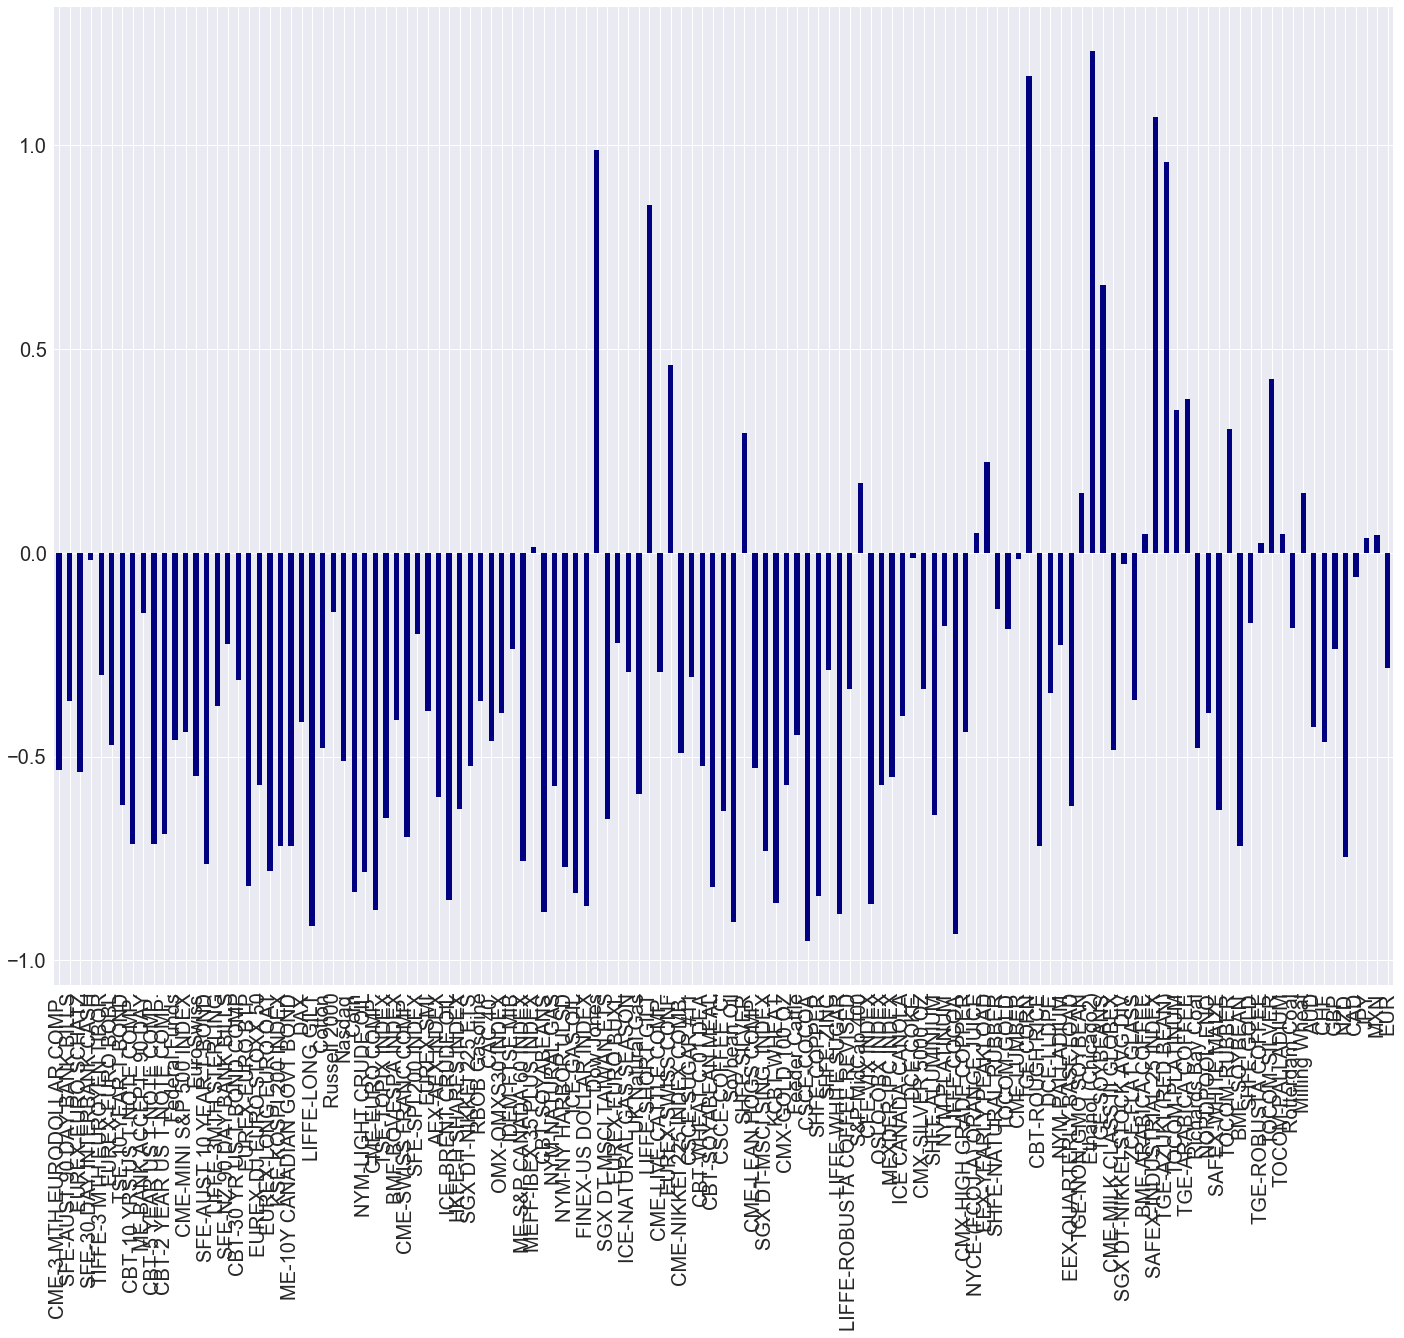

In [174]:
data['2000':'2016'].mean().plot(kind='bar',colormap='jet')

In [208]:
full_std=((amihud['2001':'2016']-amihud['2001':'2016'].mean())/amihud['2001':'2016'].std())

In [209]:
mkt = cleansed.mean(axis=1).resample(rule='m',how='last').pct_change()
pct_rtn = cleansed.resample(rule='m',how='last').pct_change()
betas=pd.DataFrame()
tstats=pd.DataFrame()
for m in data.columns:
    #if data[m].count()<36:
    #    print(m)
    #    continue
    ind = data[m].dropna()['2000':'2016'].index
    df = pd.DataFrame()
    df['Liquidity']=data[m].dropna()['2000':'2016']
   
    #ind = full_std[m].dropna()['2000':'2016'].index
    #df = pd.DataFrame()
    #df['Liquidity']=full_std[m].dropna()['2000':'2016']
    df['Market']=mkt
    #df['Value']=get_aqr_factors('All').VAL
    #df['Momentum']=get_aqr_factors('All').MOM
    res=sm.OLS(pct_rtn[m].ix[ind],sm.add_constant(df)).fit()
    betas[m]=res.params
    tstats[m]=res.tvalues

/Users/mrefermat/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  """Entry point for launching an IPython kernel.
/Users/mrefermat/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  
/Users/mrefermat/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


In [210]:
betas.T.round(2).abs().mean()

const        0.005276
Liquidity    0.007008
Market       0.340236
dtype: float64

In [211]:
betas.T.columns

Index(['const', 'Liquidity', 'Market'], dtype='object')

In [212]:
reg=betas.T[['Liquidity','Market']]

In [213]:
#res1=sm.OLS(pct_rtn['2000':'2016'].median(),sm.add_constant(reg)).fit()
res1=sm.OLS(pct_rtn['2000':'2016'].mean(),sm.add_constant(reg)).fit()

In [214]:
print(res1.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.219
Model:                            OLS   Adj. R-squared:                  0.207
Method:                 Least Squares   F-statistic:                     17.41
Date:                Thu, 12 Jul 2018   Prob (F-statistic):           2.17e-07
Time:                        16:42:48   Log-Likelihood:                 517.96
No. Observations:                 127   AIC:                            -1030.
Df Residuals:                     124   BIC:                            -1021.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0039      0.000      8.235      0.0

# Correcting the way I perform the second step

Second stage is cross sectional regression across time periods using estimated 

In [269]:
lambdas=pd.DataFrame()
for i in pct_rtn['2000':'2016'].index:
    ind=pct_rtn.ix[i].dropna().index
    res2=sm.OLS(pct_rtn.ix[i].T[ind],sm.add_constant(reg.loc[ind])).fit()
    lambdas[i]=res2.params

In [275]:
lambdas.T.mean()*12

const        0.040307
Liquidity    1.733609
Market       0.074046
dtype: float64

In [260]:
reg.loc[ind].head()

,Liquidity,Market
CME-3 MTH EURODOLLAR COMP.,0.000811,-0.002146
SFE-AUST 90 DAY BANK BILLS,0.000876,-0.008237
EUREX-EURO SCHATZ,0.000233,-0.017234
TIFFE-3 MTH EUROYEN TIBOR,0.000046,-0.000305
EUREX-EURO BOBL,-0.000457,-0.039214


const        0.014629
Liquidity    2.269649
Market      -0.008250
dtype: float64

In [265]:
print(res2.summary())

                             OLS Regression Results                            
Dep. Variable:     2000-05-31 00:00:00   R-squared:                       0.122
Model:                             OLS   Adj. R-squared:                  0.103
Method:                  Least Squares   F-statistic:                     6.330
Date:                 Thu, 12 Jul 2018   Prob (F-statistic):            0.00267
Time:                         16:59:47   Log-Likelihood:                 98.993
No. Observations:                   94   AIC:                            -192.0
Df Residuals:                       91   BIC:                            -184.4
Df Model:                            2                                         
Covariance Type:             nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0146      0.013      1.10

In [6]:
sector_rtns={}
d_map=sector_map(amihud)
for sect in d_map.keys():
    sector_rtns[sect]=cleansed[d_map[sect]].dropna(how='all')

In [34]:
results_df=pd.DataFrame()
for sect in sector_resid.keys():
    c_matrix=[]
    tstats=[]
    for t in [0,1]:
        for ent in [0,1]:
            data=pd.DataFrame(sector_resid[sect].stack()) 
            px=pd.DataFrame(sector_rtns[sect].resample(rule='m',how='last').pct_change().shift().stack())
            ind=data.index
            px=px.loc[ind]
            res=lm.PanelOLS(px.to_panel()[0],
                    data.to_panel()[0], 
                    time_effects=t,
                    entity_effects=ent).fit(cov_type='clustered',cluster_time=True)
            c_matrix.append(res.params.Exog)
            tstats.append(res.tstats.Exog)
    results_df[sect]=pd.Series(c_matrix)/10000.0
    results_df[sect + 'Tstats']=pd.Series(tstats)
results_df=results_df.set_index([['None','Ent','Time','Ent and Time']])

/Users/mrefermat/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  
/Users/mrefermat/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DeprecationWarning: 
Panel is deprecated and will be removed in a future version.
The recommended way to represent these types of 3-dimensional data are with a MultiIndex on a DataFrame, via the Panel.to_frame() method
Alternatively, you can use the xarray package http://xarray.pydata.org/en/stable/.
Pandas provides a `.to_xarray()` method to help automate this conversion.

  # This is added back by InteractiveShellApp.init_path()
/Users/mrefermat/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: 
Panel is deprecated and will be removed in a future version.
The recommended way to represent these types of 3-dimensional data are with a MultiIndex on a DataFrame, via the Panel.to_frame() method
Alternatively

In [35]:
results_df.T.round(2)

,None,Ent,Time,Ent and Time
Equities,0.23,0.20,0.11,0.10
EquitiesTstats,2.01,1.66,2.96,2.73
Commodities,-1.32,-1.80,0.01,0.13
CommoditiesTstats,-0.27,-0.36,0.00,0.03
Currencies,-0.24,-0.24,-0.25,-0.25
CurrenciesTstats,-1.33,-1.31,-1.37,-1.19
Fixed Income,-1078.27,-1101.20,-541.79,-434.23
Fixed IncomeTstats,-1.35,-1.35,-0.52,-0.40


# FHT method

In [9]:
FHT=calculate_FHT(cleansed)

/Users/mrefermat/git/FinancePhD/LiquidityMomentum/tsmom_model3.py:53: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).count()
  nonzero=x[x==0].resample(rule='m',how='count')
/Users/mrefermat/git/FinancePhD/LiquidityMomentum/tsmom_model3.py:54: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).count()
  Z=(nonzero/x.resample(rule='m',how='count')).dropna()
/Users/mrefermat/git/FinancePhD/LiquidityMomentum/tsmom_model3.py:55: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()
  data[c]=pd.Series(norm.cdf((1+Z)/2.),index=Z.index)*2*pd.rolling_std(x,12).resample(rule='m',how='last')
/Users/mrefermat/git/FinancePhD/LiquidityMomentum/tsmom_model3.py:55: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  data[c]=pd.Series(norm.cdf((1+Z)/2.),index=Z.index)*2*pd.rolling_std(x,12).resample(

In [10]:
sector_resid_FHT={}
sector_rsq_FHT={}
d_map=sector_map(amihud)
for sect in d_map.keys():
    sector_data={}
    rsq=pd.Series()
    for mkt in d_map[sect]:
        ind2=FHT[mkt].dropna().index
        ind=FHT[mkt].shift().loc[ind2].dropna().index
        res=sm.OLS(FHT[mkt].shift().loc[ind],FHT[mkt].loc[ind]).fit()
        sector_data[mkt]=res.resid
        rsq[mkt]=res.rsquared
    sector_resid_FHT[sect]=pd.DataFrame(sector_data)
    sector_rsq_FHT[sect]=rsq.mean()

In [11]:
results_df_FHT=pd.DataFrame()
for sect in sector_resid_FHT.keys():
    c_matrix=[]
    tstats=[]
    for t in [0,1]:
        for ent in [0,1]:
            data=pd.DataFrame(sector_resid_FHT[sect].stack()) 
            px=pd.DataFrame(sector_rtns[sect].resample(rule='m',how='last').pct_change().shift().stack())
            ind=data.index
            px=px.loc[ind]
            res=lm.PanelOLS(px.to_panel()[0],
                    data.to_panel()[0], 
                    time_effects=t,
                    entity_effects=ent).fit(cov_type='clustered',cluster_time=True)
            c_matrix.append(res.params.Exog)
            tstats.append(res.tstats.Exog)
    results_df_FHT[sect]=pd.Series(c_matrix)*100
    results_df_FHT[sect + 'Tstats']=pd.Series(tstats)
results_df_FHT=results_df_FHT.set_index([['None','Ent','Time','Ent and Time']])

/Users/mrefermat/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  
/Users/mrefermat/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DeprecationWarning: 
Panel is deprecated and will be removed in a future version.
The recommended way to represent these types of 3-dimensional data are with a MultiIndex on a DataFrame, via the Panel.to_frame() method
Alternatively, you can use the xarray package http://xarray.pydata.org/en/stable/.
Pandas provides a `.to_xarray()` method to help automate this conversion.

  # This is added back by InteractiveShellApp.init_path()
/Users/mrefermat/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: 
Panel is deprecated and will be removed in a future version.
The recommended way to represent these types of 3-dimensional data are with a MultiIndex on a DataFrame, via the Panel.to_frame() method
Alternatively

In [12]:
results_df_FHT.T.round(2)

,None,Ent,Time,Ent and Time
Equities,44.30,33.83,74.70,71.50
EquitiesTstats,1.14,0.85,1.74,1.62
Commodities,-0.42,-0.50,-0.14,-0.17
CommoditiesTstats,-1.62,-2.35,-0.59,-0.73
Currencies,50.91,61.17,53.04,63.26
CurrenciesTstats,0.46,0.50,0.47,0.44
Fixed Income,-25.16,-36.86,-34.87,-40.38
Fixed IncomeTstats,-0.60,-0.84,-0.84,-0.92


# Presentation
First rsquares of residuals

In [36]:
print(results_df.T.round(2).to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &     None &      Ent &    Time &  Ent and Time \\
\midrule
Equities           &     0.23 &     0.20 &    0.11 &          0.10 \\
EquitiesTstats     &     2.01 &     1.66 &    2.96 &          2.73 \\
Commodities        &    -1.32 &    -1.80 &    0.01 &          0.13 \\
CommoditiesTstats  &    -0.27 &    -0.36 &    0.00 &          0.03 \\
Currencies         &    -0.24 &    -0.24 &   -0.25 &         -0.25 \\
CurrenciesTstats   &    -1.33 &    -1.31 &   -1.37 &         -1.19 \\
Fixed Income       & -1078.27 & -1101.20 & -541.79 &       -434.23 \\
Fixed IncomeTstats &    -1.35 &    -1.35 &   -0.52 &         -0.40 \\
\bottomrule
\end{tabular}



In [13]:
print(results_df_FHT.T.round(2).to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &   None &    Ent &   Time &  Ent and Time \\
\midrule
Equities           &  44.30 &  33.83 &  74.70 &         71.50 \\
EquitiesTstats     &   1.14 &   0.85 &   1.74 &          1.62 \\
Commodities        &  -0.42 &  -0.50 &  -0.14 &         -0.17 \\
CommoditiesTstats  &  -1.62 &  -2.35 &  -0.59 &         -0.73 \\
Currencies         &  50.91 &  61.17 &  53.04 &         63.26 \\
CurrenciesTstats   &   0.46 &   0.50 &   0.47 &          0.44 \\
Fixed Income       & -25.16 & -36.86 & -34.87 &        -40.38 \\
Fixed IncomeTstats &  -0.60 &  -0.84 &  -0.84 &         -0.92 \\
\bottomrule
\end{tabular}

